In [19]:
import os
import scipy.io as sio
from tqdm import tqdm 

import matplotlib.pyplot as plt

from src.config import DATA_DIR, TRAINING_DIR

In [20]:
def print_hea_file(hea_file):
    with open(hea_file, 'r') as f:
        print(f.read())

In [21]:
sample_hea_file = [os.path.join(content[0], filename) for content in os.walk(TRAINING_DIR) for filename in content[2] if filename.endswith('.hea')][0]
print_hea_file(sample_hea_file) 

A05969 1 300 9000 00:48:00 1/12/2000 
A05969.mat 16+24 1000/mV 16 0 -113 0 0 ECG 



The content of the .hea file is a header file associated with an ECG recording in the WFDB (WaveForm DataBase) format, commonly used in PhysioNet databases.

First Line: General Information

- A05969: The record name or identifier.
- 1: The number of signals (leads) in the file. In this case, there's only one signal.
- 300: The sampling frequency of the ECG signal in Hertz (Hz). This means the ECG data was sampled 300 times per second.
- 9000: The total number of samples in each signal. Given the sampling frequency, this suggests the total duration of the ECG recording is 30 seconds (9000 samples / 300 samples per second).
- 00:48:00 1/12/2000: The time and date of the start of the recording.

Second Line: Signal-Specific Information

- A05969.mat: The name of the file containing the actual ECG signal data.
- 16+24: The format of the data in the file. This typically refers to the ADC (Analog-to-Digital Converter) resolution. It's an indication of the bit-depth used for storing each sample.
- 1000/mV: The amplitude resolution of the signal. Here, it indicates that 1000 digital units of the file correspond to 1 millivolt (mV) of ECG signal.
- 16: The initial value of the signal (offset). It's the value of the first sample.
- 0 -113 0 0: These are typically the baseline, ADC gain, first value, and checksum of the signal, respectively. The -113 is likely the baseline value, which indicates the ECG signal's offset from zero.
- ECG: Label or description of the signal. Here, it simply indicates that the signal is an ECG.

In [26]:
def load_ecg(ecg_file):
    ecg = sio.loadmat(ecg_file)['val'].squeeze()
    print(ecg.shape)
    return ecg

def plot_ecg(ecg, title='ECG'):
    plt.plot(ecg)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.show()

(9000,)


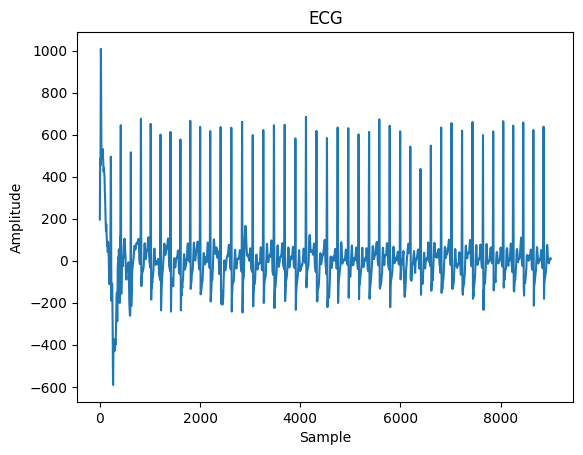

In [27]:
sample_hea_file = [os.path.join(content[0], filename) for content in os.walk(TRAINING_DIR) for filename in content[2] if filename.endswith('.mat')][0]
ecg = load_ecg(sample_hea_file)
plot_ecg(ecg)

In [30]:
def load_dataset(data_path, labels_file_path):
    # read the labels file and get the patient ids and their corresponding labels
    with open(labels_file_path, 'r') as f:
        labels = f.readlines()
        labels = [label.strip().split(',') for label in labels]
        
    # ecg data files are inside subdirectories; label[0] is the patient id and patient_id[:3] is the subdirectory in which the ecg data is stored for that patient
    dataset = []
    for label in tqdm(labels):
        patient_id = label[0]
        label = label[1]
        hea_file = os.path.join(data_path, patient_id[:3], patient_id + '.hea')
        ecg_file = os.path.join(data_path, patient_id[:3], patient_id + '.mat')
        dataset.append(
            {
                'patient_id': patient_id,
                'label': label,
                'hea_file': hea_file,
                'ecg_file': ecg_file
            }
        )
    
    return dataset

labels_file = os.path.join(DATA_DIR, 'REFERENCE-v3.csv')
dataset = load_dataset(TRAINING_DIR, labels_file)

100%|██████████| 8528/8528 [00:00<00:00, 440152.89it/s]


(9000,)


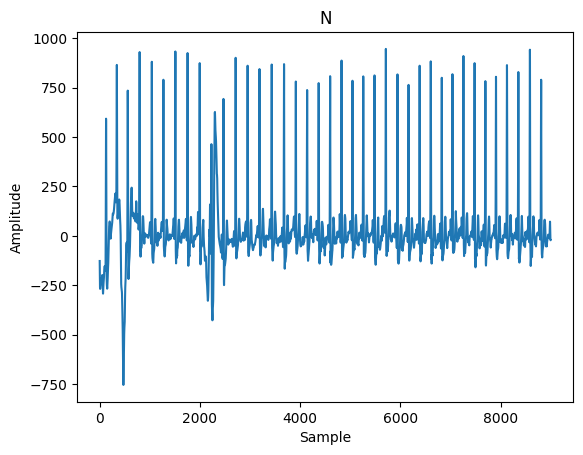

(9000,)


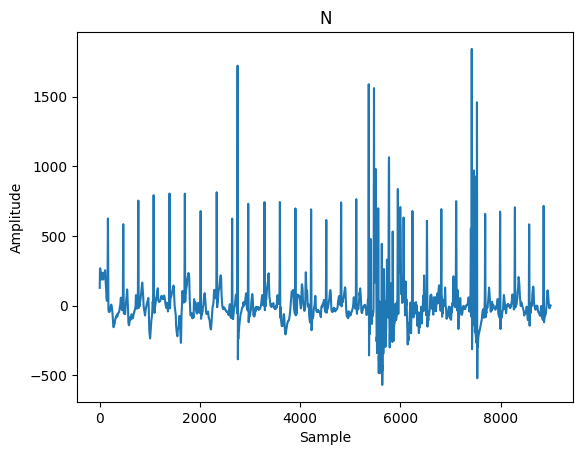

(18000,)


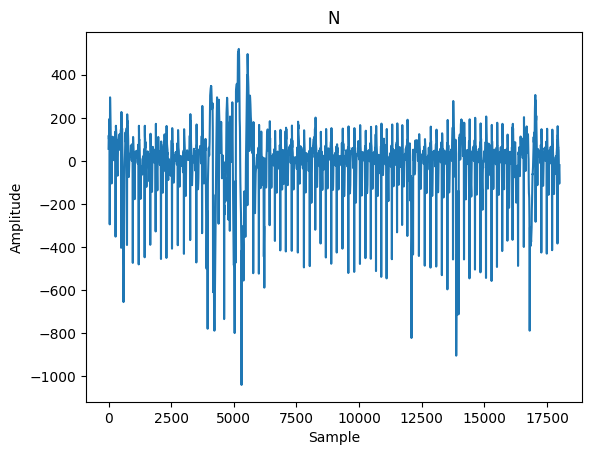

(9000,)


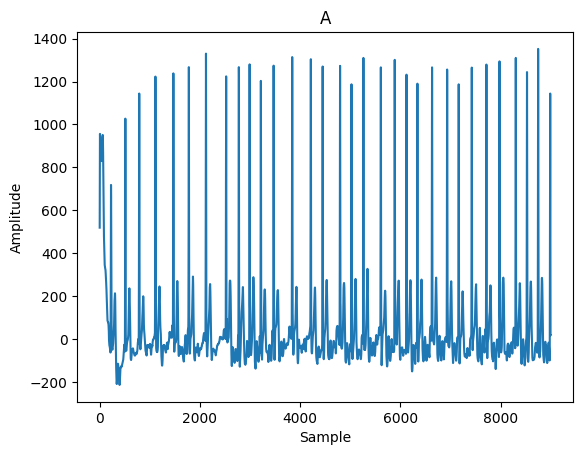

(18000,)


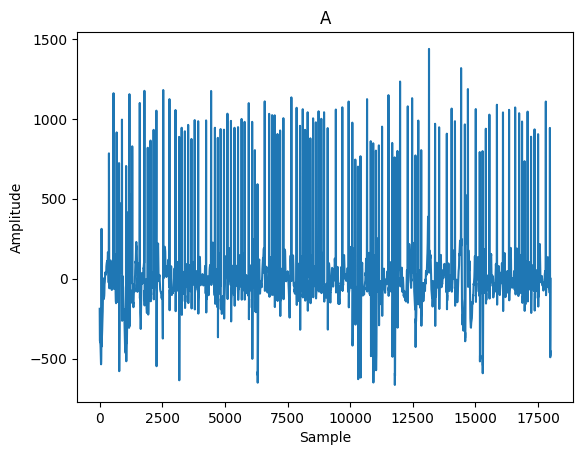

In [33]:
for dataset_item in dataset[:5]:
    ecg = load_ecg(dataset_item['ecg_file'])
    plot_ecg(ecg, title=dataset_item['label'])
    

In [2]:
%%writefile ../src/data/load_data.py
import os
import scipy.io as sio
from tqdm import tqdm
from src.config import DATA_DIR, TRAINING_DIR

def load_dataset(data_path):
    
    labels_file_path = os.path.join(DATA_DIR, 'REFERENCE-v3.csv')
    
    # read the labels file and get the patient ids and their corresponding labels
    with open(labels_file_path, 'r') as f:
        labels = f.readlines()
        labels = [label.strip().split(',') for label in labels]
        
    # ecg data files are inside subdirectories; label[0] is the patient id and patient_id[:3] is the subdirectory in which the ecg data is stored for that patient
    dataset = []
    for label in tqdm(labels):
        patient_id = label[0]
        label = label[1]
        hea_file = os.path.join(data_path, patient_id[:3], patient_id + '.hea')
        ecg_file = os.path.join(data_path, patient_id[:3], patient_id + '.mat')
        dataset.append(
            {
                'patient_id': patient_id,
                'label': label,
                'hea_file': hea_file,
                'ecg_file': ecg_file
            }
        )
    
    return dataset


def load_ecg(ecg_file):
    ecg = sio.loadmat(ecg_file)['val'].squeeze()
    return ecg


def parse_header(header_file):
    with open(header_file, 'r') as file:
        lines = file.readlines()

    header_info = {}
    
    # First line
    parts = lines[0].strip().split()
    header_info['record_name'] = parts[0]
    header_info['n_leads'] = int(parts[1])
    header_info['sample_rate'] = int(parts[2])
    header_info['n_samples'] = int(parts[3])
    header_info['datetime'] = parts[4] + ' ' + parts[5]

    # Second line
    parts = lines[1].strip().split()
    header_info['file_name'] = parts[0]
    header_info['signal_details'] = ' '.join(parts[1:])

    return header_info

Overwriting ../src/data/load_data.py


In [3]:
from src.data.load_data import load_dataset
from src.config import TRAINING_DIR
dataset = load_dataset(TRAINING_DIR)

100%|██████████| 8528/8528 [00:00<00:00, 497843.01it/s]
